# SOC From Voltage
This notebook goes over the method of determining energy in a cell given its discharge voltage curve. The formulas/functions derived here are used in `soc_from_voltage.py`.

Determine the usable energy available given the minimum module voltage.
References [cell datasheet for Sanyo 18650GA](https://drive.google.com/drive/folders/1RvQXfiDs2BZF8OOm2UOL5naPD5k6kQ0B)

## Derivation:
Energy is equal to charge times voltage.
$$U = QV$$

In differential form, we get
$$dU = V\,dQ$$

Because of the relationship between charge and voltage in a cell, $V$ is a function of $Q$. That is, for each state of charge, there is a corresponding cell voltage dictated by the battery chemistry and described in the datasheet.

$$dU = V(Q)\,dQ$$

Thus for any cell with charge $Q$, we get the usable energy by the formula

$$U(Q) = \int_{Q_{empty}}^{Q} V(Q)\,dQ$$

where $Q_{empty}$ is the charge at which the voltage is not sufficient for the car's function. In our case, `MIN_VOLTAGE` = 2.7V.

Finally, Since $V(Q)$ is strictly decreasing we can take its inverse, $Q(V)$ and compose this with our energy function $U(Q)$.

$$U(V) = U(Q(V))$$

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## 2. Define points on the graph
This will define our function $V(Q)$.

In [2]:
# Points extracted from datasheet in ``data_analysis/data/battery_cell_datasheet.png`` using ``plot_points.ipynb``.
# mAh is discharge from full
points_2A = np.array([
    [5.169867060561383, 4.1688311688311686], [15.509601181683795, 4.051948051948052],
    [77.54800590841933, 4.0], [144.75627769571625, 3.9935064935064934],
    [242.9837518463811, 3.9805194805194803], [398.0797636632201, 3.9415584415584415],
    [532.4963072378139, 3.909090909090909], [677.2525849335302, 3.8636363636363633],
    [811.669128508124, 3.831168831168831], [956.4254062038405, 3.779220779220779],
    [1090.8419497784344, 3.7532467532467533], [1261.4475627769566, 3.7012987012987013],
    [1432.0531757754798, 3.662337662337662], [1581.9793205317574, 3.6103896103896105],
    [1731.9054652880352, 3.571428571428571], [1881.8316100443128, 3.5259740259740258],
    [2011.0782865583458, 3.4935064935064934], [2140.3249630723776, 3.4675324675324672],
    [2269.5716395864106, 3.428571428571428], [2403.9881831610046, 3.409090909090909],
    [2548.744460856721, 3.37012987012987], [2698.6706056129988, 3.331168831168831],
    [2817.5775480059087, 3.2857142857142856], [2936.484490398818, 3.233766233766233],
    [3039.881831610044, 3.1363636363636362], [3127.769571639586, 3.0129870129870127],
    [3194.977843426883, 2.9155844155844157], [3246.676514032496, 2.7987012987012987],
    [3282.865583456425, 2.701298701298701], [3319.0546528803548, 2.5974025974025974],
    [3344.9039881831613, 2.5129870129870127]
])
points_increasing_voltage = np.flipud(points_2A)
MIN_VOLTAGE = 2.7
points_usable_energy = points_increasing_voltage[points_increasing_voltage[:, 1] > MIN_VOLTAGE]

max_discharge_mah = points_usable_energy[0][0]  # further discharging results in < 2.7V

# get remaining charge instead
curve_points_mah_v = points_usable_energy
curve_points_mah_v[:, 0] = max_discharge_mah - points_usable_energy[:, 0]


## 3. Interpolate $V(Q)$ at `q_vals`

In [3]:
num_points = 500
q_vals = np.linspace(0, max_discharge_mah, num_points)

xp = curve_points_mah_v[:, 0]
yp = curve_points_mah_v[:, 1]
points_mah_v = np.interp(q_vals, xp, yp)

## 4. Integrate $V(Q)$ to get $U(Q)$

In [4]:
delta_x = max_discharge_mah / num_points
print(delta_x)      
energy_wh = np.cumsum(points_mah_v) * delta_x / 1000

6.56573116691285


## 5. Plot the results

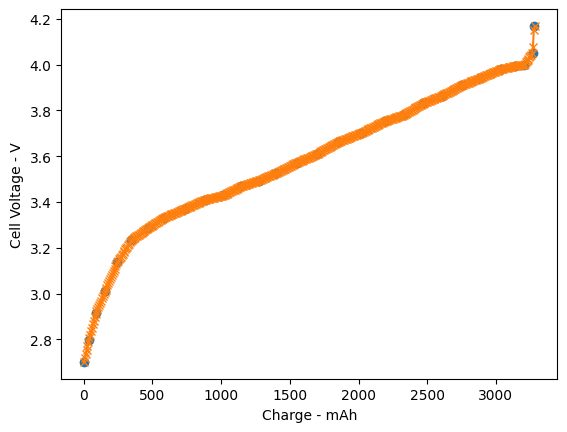

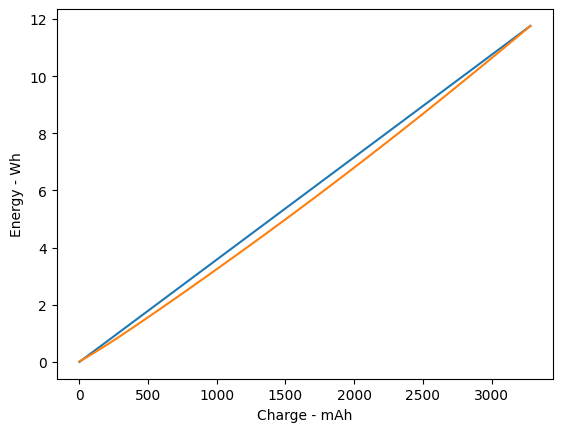

In [5]:
plt.plot(xp, yp, 'o')
plt.plot(q_vals, points_mah_v, '-x')
plt.xlabel('Charge - mAh')
plt.ylabel('Cell Voltage - V')
plt.show()
plt.plot([0, q_vals[-1]], [0, energy_wh[-1]])
plt.plot(q_vals, energy_wh)
plt.xlabel('Charge - mAh')
plt.ylabel('Energy - Wh')
plt.show()

We can now interpolate `energy_wh` to obtain battery energy as a function of charge. We can also take the set of points `x_vals`, `y_interp` and invert then interpolate them to obtain charge as a function of voltage. Composing these two functions, we get energy as a function of voltage.

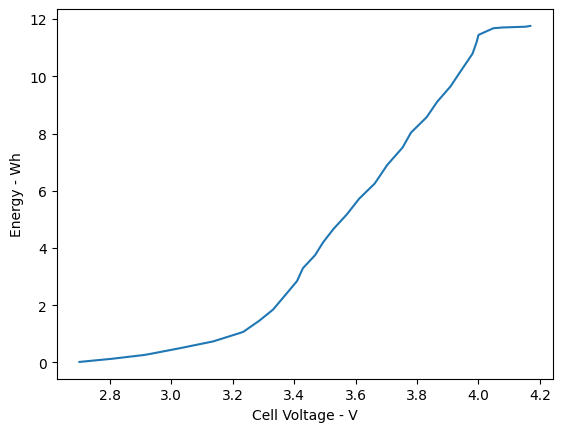

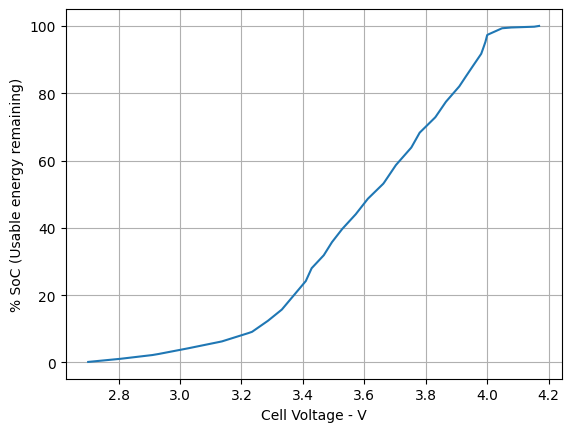

In [6]:
from scipy.interpolate import CubicSpline
energy_of_charge = CubicSpline(q_vals, energy_wh)
charge_of_voltage = CubicSpline(points_mah_v, q_vals)
energy_of_voltage = CubicSpline(points_mah_v, energy_of_charge(charge_of_voltage(points_mah_v)))

plt.plot(points_mah_v, energy_of_voltage(points_mah_v))
plt.xlabel('Cell Voltage - V')
plt.ylabel('Energy - Wh')
plt.show()

plt.plot(points_mah_v, energy_of_voltage(points_mah_v) / energy_wh[-1] * 100)
plt.xlabel('Cell Voltage - V')
plt.ylabel('% SoC (Usable energy remaining)')
plt.grid(which="both")
plt.show()

The amount of energy in a cell, determined in the first chart above matches what we expect: with a 32s13p configuration, we have 416 which gives 12 Wh/cell * 416 cells = 4992 Wh for the entire battery. This is around our expected value for the amount of energy in our battery.

## Export data for Sunbeam SoC Stage

In [15]:
print(np.stack((points_mah_v, energy_of_charge(charge_of_voltage(points_mah_v)))).tolist())

[[2.701298701298701, 2.7190057294551995, 2.736712757611698, 2.7544197857681967, 2.7721268139246953, 2.789833842081194, 2.8061265387918692, 2.821000442443328, 2.8358743460947866, 2.8507482497462453, 2.8656221533977044, 2.880496057049163, 2.895369960700622, 2.9102438643520805, 2.9216955389300074, 2.9312300925527377, 2.9407646461754675, 2.9502991997981973, 2.9598337534209276, 2.9693683070436574, 2.978902860666387, 2.988437414289117, 2.9979719679118473, 3.007506521534577, 3.016913888893141, 3.026149319264962, 3.0353847496367825, 3.0446201800086037, 3.0538556103804244, 3.063091040752245, 3.072326471124066, 3.081561901495887, 3.0907973318677078, 3.1000327622395285, 3.1092681926113492, 3.1185036229831704, 3.127739053354991, 3.1367735470941884, 3.142971006948963, 3.1491684668037374, 3.1553659266585115, 3.161563386513286, 3.1677608463680604, 3.173958306222835, 3.1801557660776094, 3.186353225932384, 3.1925506857871584, 3.1987481456419324, 3.204945605496707, 3.2111430653514814, 3.217340525206256,